#### Test BHRC Data

In [1]:
import glob, os, sys, warnings

import matplotlib.pyplot as plt
import pandas as pd

from datetime import datetime
from timeit import default_timer as timer 

import torch
from torch import nn
from torch.utils.data import DataLoader

from torch.utils.data import DataLoader
from pyprojroot import here

sys.path.insert(0, f"{here()}/src")
from cnn import MRIBaseCNN, CNNMLP, MRIDataset #Loads CNN and Custom class for loading daataset

from model_train_eval_src import eval_model
from timer import print_train_time
from plots import scatter_predicted_chronological, scatter_adjbrainage_age, scatter_bag_age, age_distribution_plot

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_columns', None)
pd.reset_option("mode.chained_assignment")

PyTorch version: 2.7.1+cu126
torchvision version: 0.22.1+cu126


In [2]:
sys.path.insert(0, f"{here()}/src")
proj_dir = here()

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

##### Load BHRC data

In [4]:
bhrc_test_pheno_directory = "/shared/uher/Murage/neptune/data/processed/2025-01-29_bhrc_all_waves.csv" 

In [5]:
bhrc = pd.read_csv(bhrc_test_pheno_directory)

In [6]:
bhrc.head()

,scan_id,scan_age,sex,site,group,depression,bpd,cantpsych,past_antpsych,iq,adhd,anxiety,psych_interview_age,pheno_age,chronological_age,brain_age,brain_age_gap,adjusted_brain_age,adjusted_brain_age_gap,cage,corrected_brain_age_gap,bag_z_scored
0,3.0,8.856947,Female,BHRC,Ctrls,No,0.0,No,No,94.0,No,No,8.59137577002053,8.856947,8.856947,9.332229,0.475281,8.927518,0.070571,-1.143053,-1.758444,-0.633231
1,15.0,12.848734,Female,BHRC,Ctrls,Yes,0.0,No,No,85.0,No,No,12.5147159479808,12.848734,12.848734,14.365569,1.516835,14.295576,1.446842,2.848734,0.292321,0.105267
2,16.0,12.013689,Male,BHRC,FHR (SMI),No,0.0,No,No,100.0,Yes,Yes,11.7180013689254,12.013689,12.013689,14.575876,2.562187,14.519869,2.506180,2.013689,1.210561,0.435933
3,19.0,12.000000,Female,BHRC,FHR (SMI),No,0.0,No,No,75.0,No,No,11.0444900752909,12.000000,12.000000,11.030887,-0.969113,10.739137,-1.260863,2.000000,-2.558795,-0.921444
4,22.0,14.425736,Female,BHRC,Ctrls,No,0.0,No,No,91.0,No,No,13.4592744695414,14.425736,14.425736,15.661111,1.235375,15.677272,1.251536,4.425736,0.363481,0.130893


In [7]:
bhrc.columns = bhrc.columns.str.replace(' ', '')
bhrc['site'] = bhrc['site'].str.strip()

In [8]:
bhrc.site.value_counts()

site
BHRC     674
BHRC2    439
BHRC3    387
Name: count, dtype: int64

In [61]:
bhrc1 = bhrc[bhrc['site'] == 'BHRC']
bhrc2 = bhrc[bhrc['site'] == 'BHRC2']
bhrc3 = bhrc[bhrc['site'] == 'BHRC3']

In [ ]:
bhrc1.shape, bhrc2.shape, bhrc3.shape

(674, 22)

##### Baseline, 2nd time and 3rd time follow up scans

In [50]:
processed_bhrc_subjects = []

for file in os.listdir(f"/shared/uher/Murage/BrainAgefMRI/data/test/BHRC/"):
    if file.endswith('.gz'):
        processed_bhrc_subjects.append(file)

bhrc_ = pd.DataFrame(processed_bhrc_subjects, columns=['participant'])

In [51]:
processed_bhrc2_subjects = []

for file in os.listdir(f"/shared/uher/Murage/BrainAgefMRI/data/test/BHRC2/"):
    if file.endswith('.gz'):
        processed_bhrc2_subjects.append(file)

bhrc_2 = pd.DataFrame(processed_bhrc2_subjects, columns=['participant'])

In [52]:
processed_bhrc3_subjects = []

for file in os.listdir(f"/shared/uher/Murage/BrainAgefMRI/data/test/BHRC3/"):
    if file.endswith('.gz'):
        processed_bhrc3_subjects.append(file)

bhrc_3 = pd.DataFrame(processed_bhrc3_subjects, columns=['participant'])

In [53]:
bhrc_.shape, bhrc_2.shape, bhrc_3.shape

((742, 1), (466, 1), (419, 1))

In [55]:
bhrc_[['participant_id', 'meh', 'meh2']] = bhrc_['participant'].str.split('.', expand=True)
bhrcT1 = bhrc_[['participant_id']]

In [56]:
bhrc_2[['participant_id', 'meh', 'meh2']] = bhrc_2['participant'].str.split('.', expand=True)
bhrcT2 = bhrc_2[['participant_id']]

In [57]:
bhrc_3[['participant_id', 'meh', 'meh2']] = bhrc_3['participant'].str.split('.', expand=True)
bhrcT3 = bhrc_3[['participant_id']]

In [58]:
bhrcT1 =bhrcT1.assign(filename=bhrcT1['participant_id'] + '.nii.gz')
bhrcT2 =bhrcT2.assign(filename=bhrcT2['participant_id'] + '.nii.gz')
bhrcT3 =bhrcT3.assign(filename=bhrcT3['participant_id'] + '.nii.gz')

In [62]:
bhrc2.sample(5)

,scan_id,scan_age,sex,site,group,depression,bpd,cantpsych,past_antpsych,iq,adhd,anxiety,psych_interview_age,pheno_age,chronological_age,brain_age,brain_age_gap,adjusted_brain_age,adjusted_brain_age_gap,cage,corrected_brain_age_gap,bag_z_scored
1457,2298.0,16.084873,Female,BHRC2,FHR (SMI),No,0.0,No,No,,No,Yes,15.1101984941821,16.084873,16.084873,17.368118,1.283245,17.497795,1.412922,6.084873,0.805212,0.289964
1266,1315.0,15.263518,Female,BHRC2,Ctrls,No,0.0,No,No,,No,No,13.8617385352498,15.263518,15.263518,17.558342,2.294824,17.700670,2.437152,5.263518,1.690658,0.608820
1380,1890.0,15.627652,Female,BHRC2,FHR (SMI),No,0.0,No,No,,No,No,14.6201232032854,15.627652,15.627652,17.580675,1.953023,17.724487,2.096835,5.627652,1.411869,0.508426
1062,18.0,13.462012,Male,BHRC2,FHR (SMI),No,0.0,No,No,,No,Yes,12.1095140314853,13.462012,13.462012,16.310032,2.848020,16.369347,2.907334,3.462012,1.856439,0.668520
1337,1685.0,11.759069,Female,BHRC2,FHR (SMI),No,0.0,No,No,,No,No,10.6885694729637,11.759069,11.759069,14.024626,2.265557,13.931960,2.172891,1.759069,0.834249,0.300420


In [64]:
bhrcT1['scan_id'] = bhrcT1['participant_id'].str.split('-').str[-1]
bhrcT2['scan_id'] = bhrcT2['participant_id'].str.split('-').str[-1]
bhrcT3['scan_id'] = bhrcT3['participant_id'].str.split('-').str[-1]

In [66]:
bhrcT2.sample()

,participant_id,filename,scan_id
285,BHRC2-sub-02239,BHRC2-sub-02239.nii.gz,02239


In [67]:
bhrcT1['scan_id'] = bhrcT1['scan_id'].astype(int)
bhrcT2['scan_id'] = bhrcT2['scan_id'].astype(int)
bhrcT3['scan_id'] = bhrcT3['scan_id'].astype(int)

In [69]:
bhrcT2.sample()

,participant_id,filename,scan_id
183,BHRC2-sub-00335,BHRC2-sub-00335.nii.gz,335


In [70]:
#bhrc1['scan_id'] = bhrc1['scan_id'].astype(int)
bhrc1.loc[:, 'scan_id'] = bhrc1['scan_id'].astype(int)
bhrc2.loc[:, 'scan_id'] = bhrc2['scan_id'].astype(int)
bhrc3.loc[:, 'scan_id'] = bhrc3['scan_id'].astype(int)

In [73]:
bhrc3.sample()

,scan_id,scan_age,sex,site,group,depression,bpd,cantpsych,past_antpsych,iq,adhd,anxiety,psych_interview_age,pheno_age,chronological_age,brain_age,brain_age_gap,adjusted_brain_age,adjusted_brain_age_gap,cage,corrected_brain_age_gap,bag_z_scored
1036,2332.0,19.403149,Male,BHRC3,Ctrls,No,0.0,No,No,,No,No,19.2717316906229,19.403149,19.403149,16.7955,-2.607649,16.887098,-2.51605,9.403149,-2.56307,-0.922983


In [74]:
bhrc_df = bhrc1.merge(bhrcT1, on='scan_id', how='left')
bhrc2_df = bhrc2.merge(bhrcT2, on='scan_id', how='left')
bhrc3_df = bhrc3.merge(bhrcT3, on='scan_id', how='left')

In [75]:
bhrc_df.shape, bhrc2_df.shape, bhrc3_df.shape

((674, 24), (439, 24), (387, 24))

In [76]:
bhrc_test = bhrc_df[['filename', 'scan_id', 'scan_age', 'sex', 'group']]
bhrc2_test = bhrc2_df[['filename', 'scan_id', 'scan_age', 'sex', 'group']]
bhrc3_test = bhrc3_df[['filename', 'scan_id', 'scan_age', 'sex', 'group']]

In [78]:
bhrc2_test.head()

,filename,scan_id,scan_age,sex,group
0,BHRC2-sub-00016.nii.gz,16.0,16.095825,Male,FHR (SMI)
1,BHRC2-sub-00018.nii.gz,18.0,13.462012,Male,FHR (SMI)
2,BHRC2-sub-00050.nii.gz,50.0,11.501711,Female,Ctrls
3,BHRC2-sub-00053.nii.gz,53.0,14.165640,Male,Ctrls
4,BHRC2-sub-00062.nii.gz,62.0,12.383299,Female,FHR (SMI)


#### Make test dataloader

In [88]:
bhrc_data_directory = "/shared/uher/Murage/BrainAgefMRI/data/test/BHRC/"
bhrc2_data_directory = "/shared/uher/Murage/BrainAgefMRI/data/test/BHRC2/"
bhrc3_data_directory = "/shared/uher/Murage/BrainAgefMRI/data/test/BHRC3/"

In [89]:
bhrc_test_dataset = MRIDataset(df=bhrc_test, id_col='filename', target_col='scan_age', root_dir=bhrc_data_directory)
bhrc2_test_dataset = MRIDataset(df=bhrc2_test, id_col='filename', target_col='scan_age', root_dir=bhrc2_data_directory)
bhrc3_test_dataset = MRIDataset(df=bhrc3_test, id_col='filename', target_col='scan_age', root_dir=bhrc3_data_directory)

#### Print first 5 test samples

In [90]:
for i in range(5):
    try:
        image, label = bhrc_test_dataset[i]
        print(f"Index: {i}, Image shape: {image.shape if hasattr(image, 'shape') else type(image)}, Label: {label}")
    except KeyError:
        print(f"Index: {i}, Image shape: {image.shape if hasattr(image, 'shape') else type(image)}, Label: {label}")

Index: 0, Image shape: torch.Size([1, 121, 145, 121]), Label: tensor([8.8569])
Index: 1, Image shape: torch.Size([1, 121, 145, 121]), Label: tensor([12.8487])
Index: 2, Image shape: torch.Size([1, 121, 145, 121]), Label: tensor([12.0137])
Index: 3, Image shape: torch.Size([1, 121, 145, 121]), Label: tensor([12.])
Index: 4, Image shape: torch.Size([1, 121, 145, 121]), Label: tensor([14.4257])


In [91]:
bhrc_test_dataloader = DataLoader(bhrc_test_dataset, batch_size=2, shuffle=False, pin_memory=True)
bhrc2_test_dataloader = DataLoader(bhrc2_test_dataset, batch_size=2, shuffle=False, pin_memory=True)
bhrc3_test_dataloader = DataLoader(bhrc3_test_dataset, batch_size=2, shuffle=False, pin_memory=True)

In [92]:
image, label = next(iter(bhrc_test_dataloader))
print(f'{image.shape}, {label}')

torch.Size([2, 1, 121, 145, 121]), tensor([[ 8.8569],
        [12.8487]])


#### Load model & test on BHRC data

In [93]:
mae = nn.L1Loss()
mse = nn.MSELoss()

In [94]:
loaded_model = CNNMLP(input_shape=1, hidden_units=32, output_shape=1).to(device)
for file in glob.glob(f"{here()}/models/????-??-??_best_cnnmlp_model.pth"):
    loaded_model.load_state_dict(torch.load(file))

In [95]:
# Evaluate best model
torch.manual_seed(42)

best_model_results = eval_model(
    model=loaded_model,
    data_loader=bhrc_test_dataloader,
    loss_fn=mae, 
    accuracy_fn=mse
)

best_model_results2 = eval_model(
    model=loaded_model,
    data_loader=bhrc2_test_dataloader,
    loss_fn=mae, 
    accuracy_fn=mse
)

best_model_results3 = eval_model(
    model=loaded_model,
    data_loader=bhrc3_test_dataloader,
    loss_fn=mae, 
    accuracy_fn=mse
)


In [96]:
best_model_results['age'].flatten().shape, best_model_results2['age'].flatten().shape, best_model_results3['age'].flatten().shape

((674,), (439,), (387,))

#### Save predictions to csv

In [99]:
bhrc_preds_df = bhrc_test.copy()
bhrc2_preds_df = bhrc2_test.copy()
bhrc3_preds_df = bhrc3_test.copy()

In [100]:
bhrc_preds_df.columns = bhrc_preds_df.columns.str.replace(' ', '')
bhrc2_preds_df.columns = bhrc2_preds_df.columns.str.replace(' ', '')
bhrc3_preds_df.columns = bhrc3_preds_df.columns.str.replace(' ', '')

In [103]:
bhrc3_preds_df.sample()

,filename,scan_id,scan_age,sex,group
90,BHRC3-sub-00775.nii.gz,775.0,21.330595,Female,FHR (SMI)


In [104]:
bhrc_preds_df["chronological_age"] = best_model_results["age"].flatten()
bhrc_preds_df["brain_age"] = best_model_results["predicted"].flatten()
bhrc_preds_df["brain_age_gap"] = bhrc_preds_df["brain_age"] - bhrc_preds_df["scan_age"] 

bhrc2_preds_df["chronological_age"] = best_model_results2["age"].flatten()
bhrc2_preds_df["brain_age"] = best_model_results2["predicted"].flatten()
bhrc2_preds_df["brain_age_gap"] = bhrc2_preds_df["brain_age"] - bhrc2_preds_df["scan_age"]  

bhrc3_preds_df["chronological_age"] = best_model_results3["age"].flatten()
bhrc3_preds_df["brain_age"] = best_model_results3["predicted"].flatten()
bhrc3_preds_df["brain_age_gap"] = bhrc3_preds_df["brain_age"] - bhrc3_preds_df["scan_age"]  

In [107]:
bhrc3_preds_df.sample(5)

,filename,scan_id,scan_age,sex,group,chronological_age,brain_age,brain_age_gap
251,BHRC3-sub-01751.nii.gz,1751.0,18.710472,Male,Ctrls,18.710472,20.351870,1.641397
352,BHRC3-sub-02285.nii.gz,2285.0,20.818617,Male,Ctrls,20.818617,19.609905,-1.208712
229,BHRC3-sub-01625.nii.gz,1625.0,20.936345,Female,Ctrls,20.936344,16.370642,-4.565703
312,BHRC3-sub-02079.nii.gz,2079.0,17.831622,Female,Ctrls,17.831623,17.183836,-0.647786
149,BHRC3-sub-01154.nii.gz,1154.0,16.019165,Male,Ctrls,16.019165,16.683144,0.663979


In [108]:
frames = [bhrc_preds_df, bhrc2_preds_df, bhrc3_preds_df]
results = pd.concat(frames)

In [111]:
results.shape, bhrc_preds_df.shape

((1500, 8), (674, 8))

In [112]:
datem = datetime.today().strftime("%Y-%m-%d")

In [113]:
results.to_csv(f"{here()}/data/processed/{datem}_bhrc_cnnmlp_predictions.csv", index=False)

#### Plots

/shared/uher/Murage/brainagecnn/brainagecnn/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 53 rows containing non-finite values.
/shared/uher/Murage/brainagecnn/brainagecnn/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_density : Removed 53 rows containing non-finite values.
/shared/uher/Murage/brainagecnn/brainagecnn/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


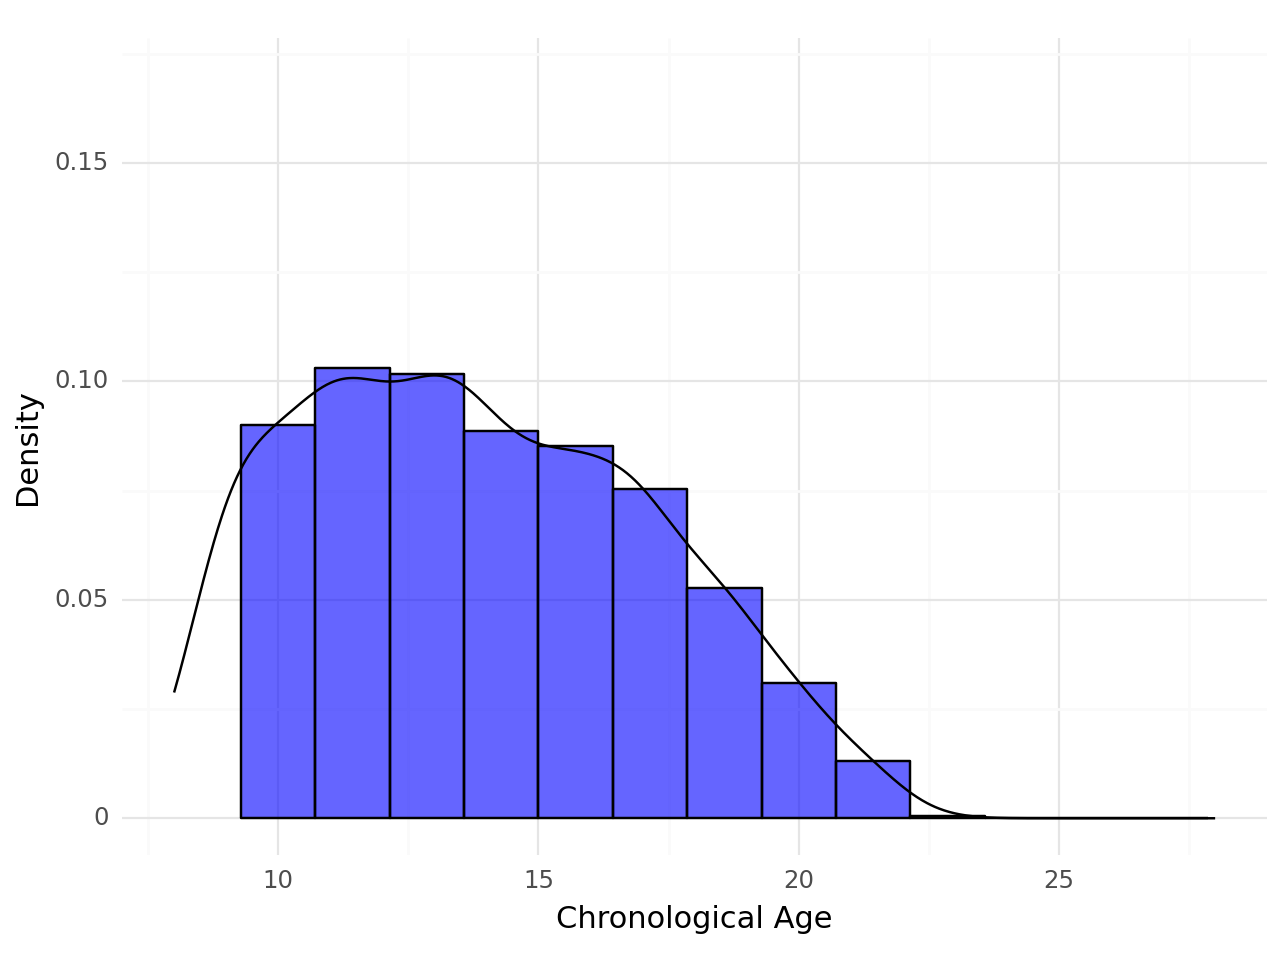

/shared/uher/Murage/brainagecnn/brainagecnn/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/shared/uher/Murage/brainagecnn/brainagecnn/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /shared/uher/Murage/brainagecnn/figures/bhrc_age_distribution.png
/shared/uher/Murage/brainagecnn/brainagecnn/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 53 rows containing non-finite values.
/shared/uher/Murage/brainagecnn/brainagecnn/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_density : Removed 53 rows containing non-finite values.


/shared/uher/Murage/brainagecnn/brainagecnn/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


In [114]:
age_distribution_plot(results, 'bhrc', 'blue')

In [115]:
results.chronological_age.describe()

count    1500.000000
mean       13.593783
std         3.478887
min         6.715948
25%        10.800137
50%        13.329226
75%        16.286790
max        22.466805
Name: chronological_age, dtype: float64

/shared/uher/Murage/brainagecnn/brainagecnn/lib/python3.11/site-packages/plotnine/scales/scale.py:143: PlotnineWarning: scale_color_cmap could not recognise parameter `cmap`
/shared/uher/Murage/brainagecnn/brainagecnn/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 53 rows containing missing values.


min age: 6.715948104858398, median: 13.32922649383545, max: 22.46680450439453


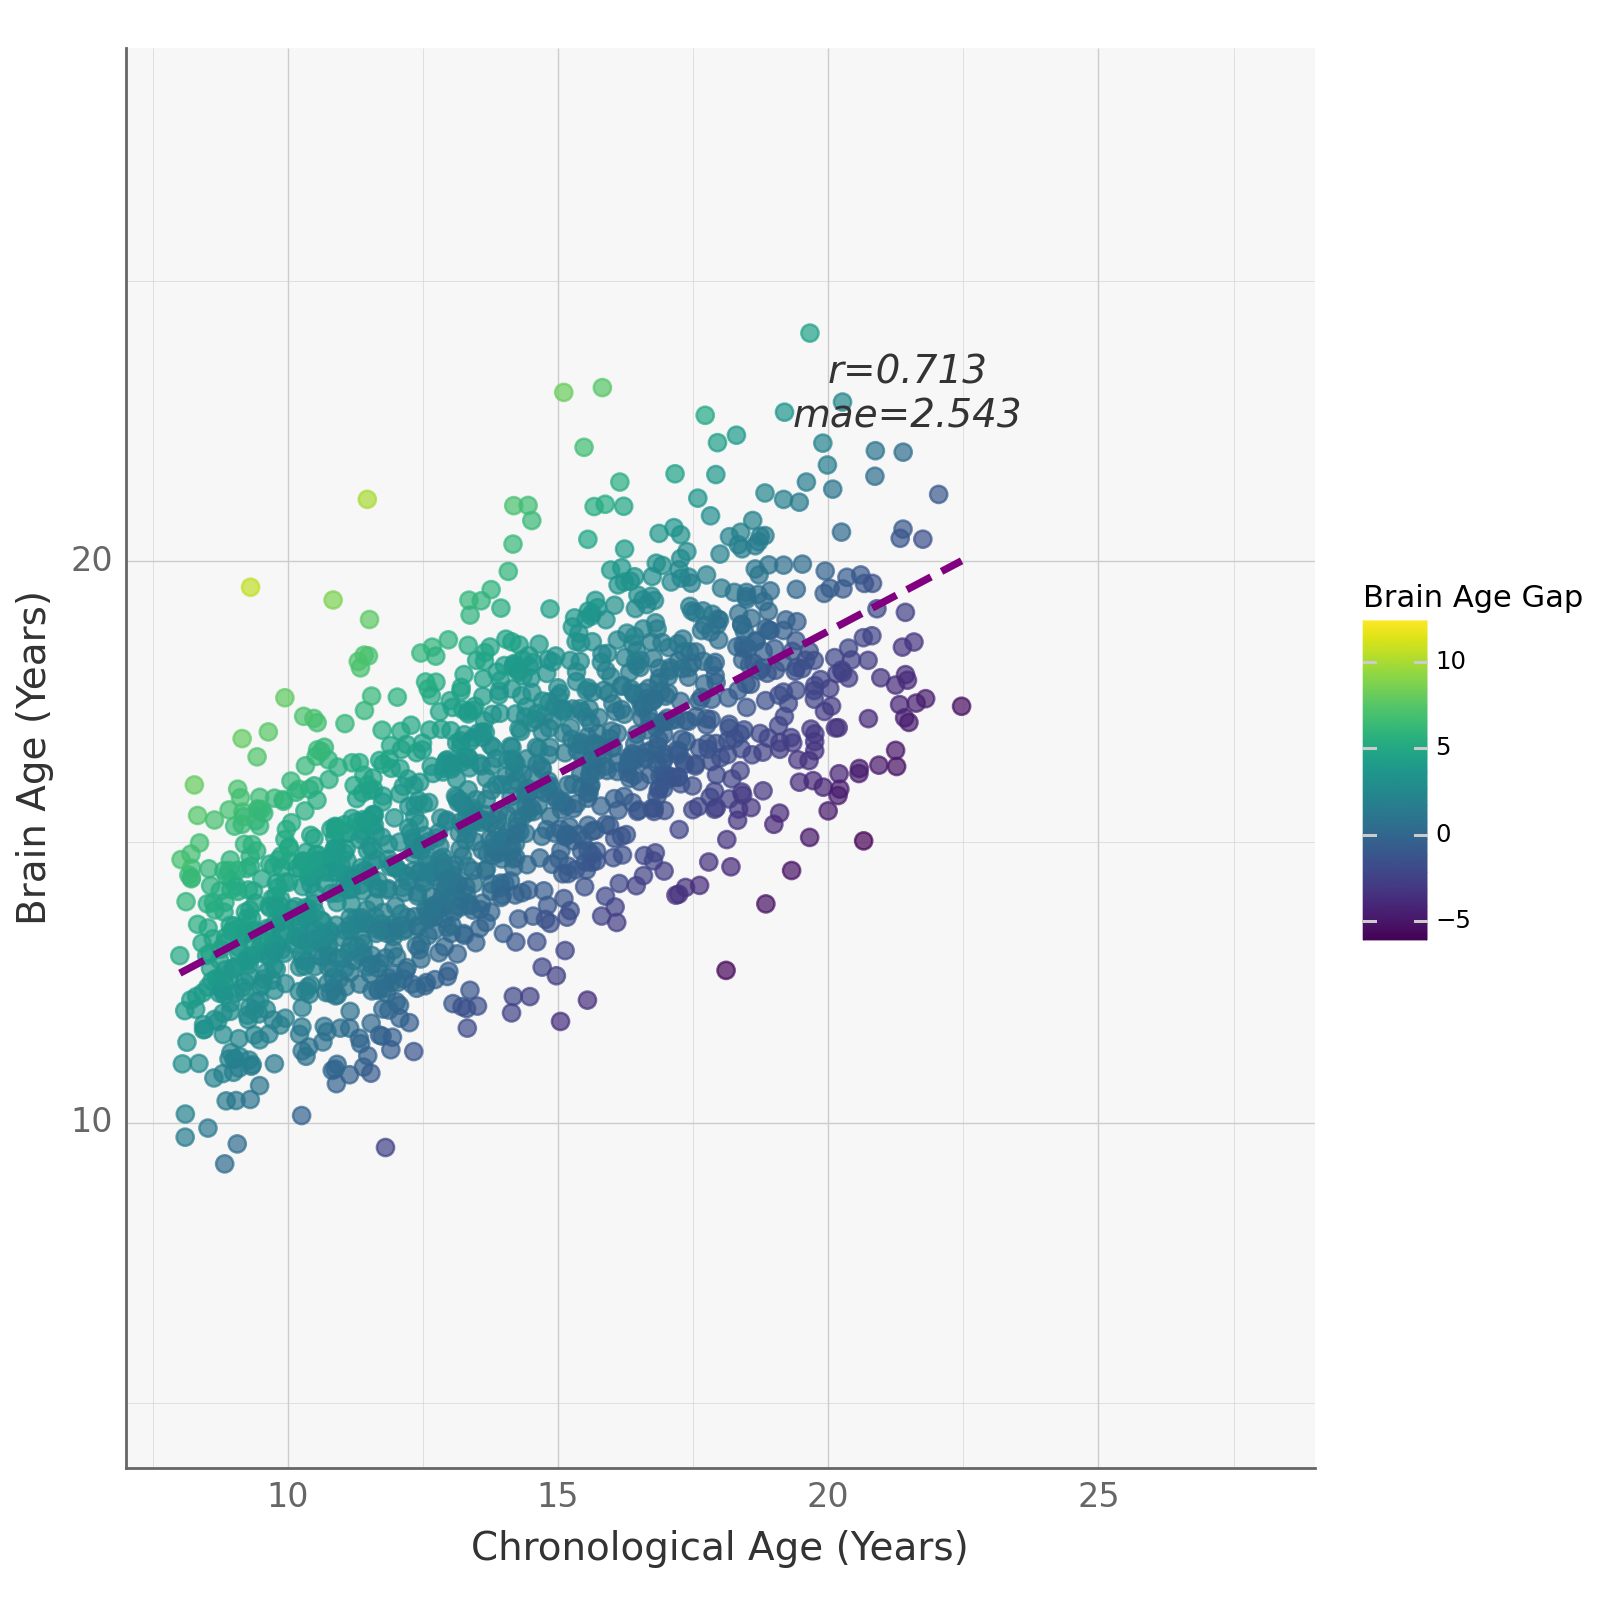

/shared/uher/Murage/brainagecnn/brainagecnn/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 8 in image.
/shared/uher/Murage/brainagecnn/brainagecnn/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /shared/uher/Murage/brainagecnn/figures/bhrc_chronological_predicted_plot.png
/shared/uher/Murage/brainagecnn/brainagecnn/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 53 rows containing missing values.


In [116]:
scatter_predicted_chronological(results, 'bhrc')

min age: 6.715948104858398, median: 13.32922649383545, max: 22.46680450439453


/shared/uher/Murage/brainagecnn/brainagecnn/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 53 rows containing missing values.


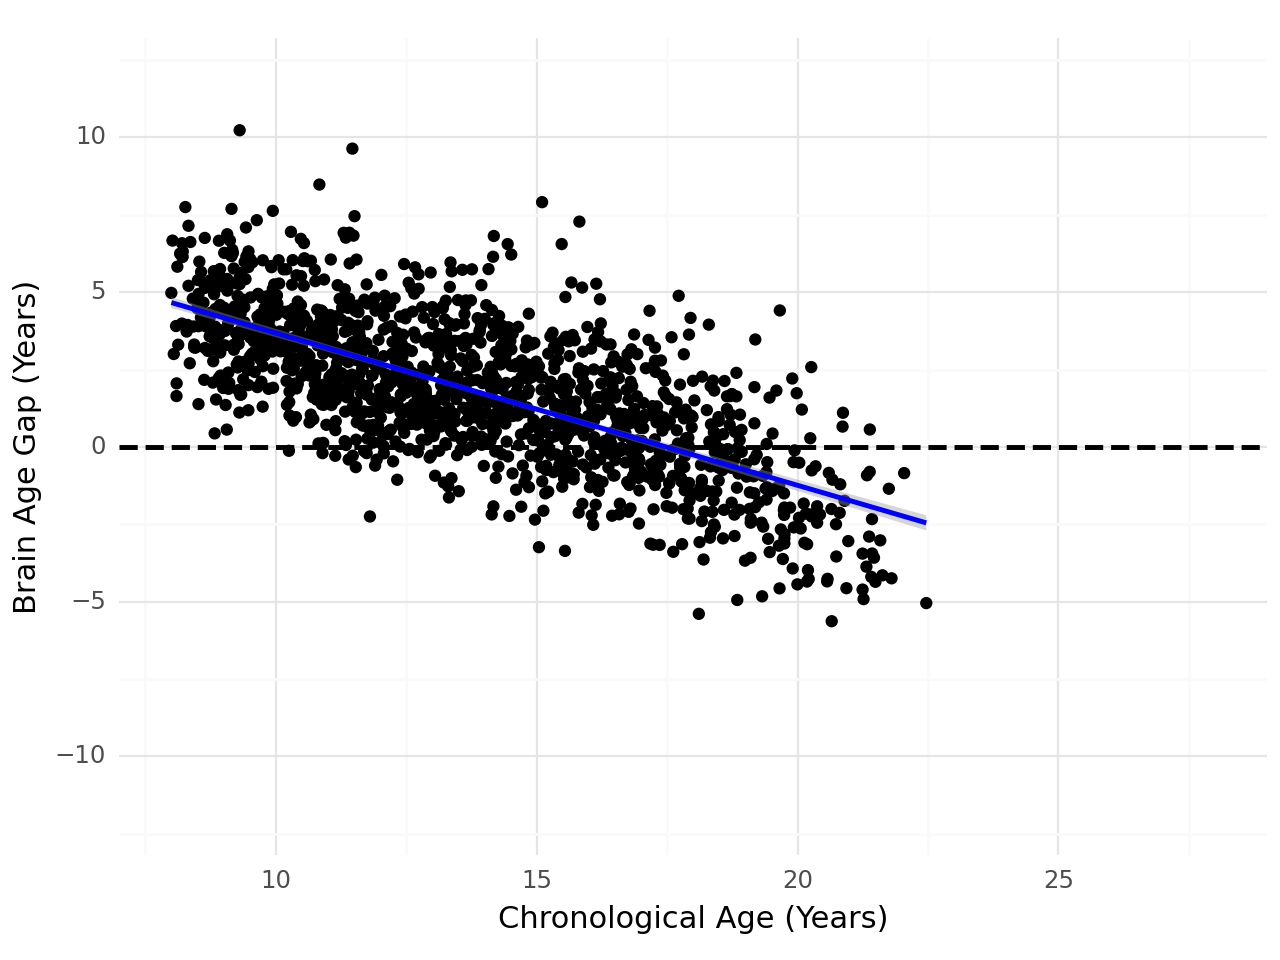

/shared/uher/Murage/brainagecnn/brainagecnn/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/shared/uher/Murage/brainagecnn/brainagecnn/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /shared/uher/Murage/brainagecnn/figures/bhrc_bag_age_plot.png
/shared/uher/Murage/brainagecnn/brainagecnn/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 53 rows containing missing values.


In [117]:
scatter_bag_age(results, "bhrc")

In [118]:
results.brain_age_gap.describe()

count    1500.000000
mean        1.920115
std         2.437846
min        -5.633002
25%         0.349732
50%         1.966587
75%         3.607442
max        11.902197
Name: brain_age_gap, dtype: float64